# Кластеризация

Кластеризация &mdash; это метод машинного обучения, который включает группировку данных в пространстве признаков. Теоретически, точки, находящиеся в одной группе, должны иметь схожие свойства, в то время как точки в разных группах должны иметь сильно отличающиеся свойства. 

Кластеризация является методом обучения без учителя и распространенным методом статистического анализа данных, используемым во многих областях. В частности используется при составлении портретов пользователей, поиска аномалий.

В анализе данных часто прибегают к кластеризации, чтобы получить ценную информацию из данных, наблюдая, в какие группы попадают точки при применении алгоритма кластеризации.


## K-means

Напомним, что сам алгоритм можно схематически представить в виде следующих шагов:

1. Инициализируем центры кластеров случайно (должно быть задано количество кластеров).
2. Относим точки к соответствующим кластерам (с минимальным расстоянием до их центра).
3. Производится пересчет центров кластеров по формуле центра масс для всех точек, принадлежащих кластеру.
4. Пункты 2-3 повторяются до тех пор пока центры кластеров перестанут меняться (сильно).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [11, 8]

Посмотрим на то, как работает метод.

In [3]:
from sklearn.cluster import KMeans

np.random.seed(123)
X1 = np.random.randn(100, 2)
X2 = np.random.randn(100, 2) - np.array([10 ,1])
X3 = np.random.randn(100, 2) - np.array([1, 10])
X = np.vstack((X1, X2, X3))
y = np.array([1] * 100 + [2] * 100 + [3] * 100)

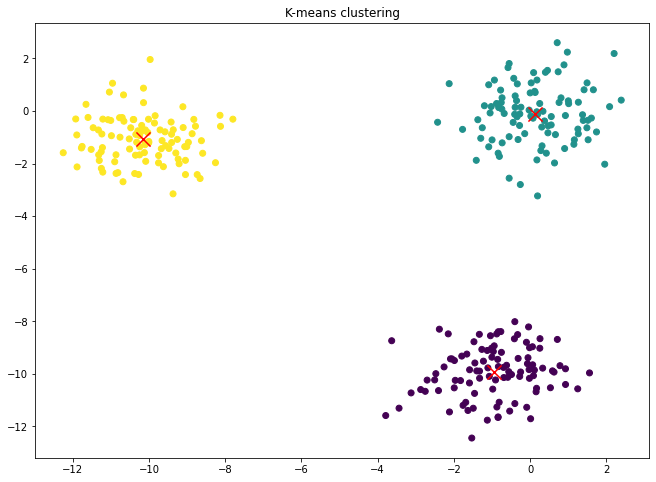

In [4]:
k_means = KMeans(n_clusters=3)
k_means = k_means.fit(X)
clusters = k_means.predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], color='red', marker='x', s=200)
plt.title('K-means clustering')
plt.show()

Посмотрим, что будет происходить, если мы не угадали с числом кластеров.

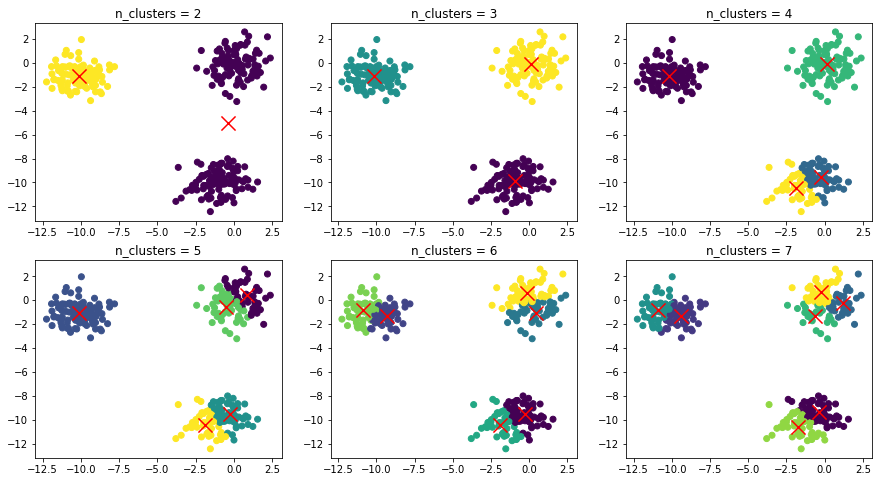

In [5]:
plt.figure(figsize=(15, 8))
for n_c in range(2, 8):
    k_means = KMeans(n_clusters=n_c)
    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    plt.subplot(2,3, n_c - 1)
    plt.scatter(X[:,0], X[:,1], c=clusters)
    plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], color='red', marker='x', s=200)
    plt.title('n_clusters = {}'.format(n_c))

plt.show()

Как мы видим, k-means обязательно пытается отдать каждому кластеру какие-то объекты и, как большинство алгоритмов кластеризации, зависит от заданного числа кластеров.

Одним из недостатков k-means является случайная инициализация центров кластеров, что может привести к различным результатам кластеризации.

Главным же достоинством является скорость алгоритма. На каждой итерации требуется пересчет только расстояний до центров кластеров.

[Визуализация работы K-Means](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)

## Качество кластеризации

Существует достаточно много способов оценить качество кластеризации. Также существуют метрики, которые используют знания об истинном разбиении, но есть и метрики, которые это не используют. Метриками, использующими истинное разбиение, являются [homogeneity_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html) и [v_measure_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html). Пример метрики, которая не использует истинное разбиение: [silhouette_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score).

In [6]:
from sklearn.metrics import silhouette_score, homogeneity_score, v_measure_score

In [7]:
n_c = 3
k_means = KMeans(n_clusters=n_c)
k_means = k_means.fit(X)
clusters = k_means.predict(X)
print('num clusters:', n_c)
print('Silhouette score:', silhouette_score(X, clusters))
print('Homogeneity score:', homogeneity_score(y, clusters))

num clusters: 3
Silhouette score: 0.8196436134448253
Homogeneity score: 1.0


Найдем число кластеров в предыдущей задаче, максимизирующее значение данных метрик.

In [8]:
silhouette = []
homogeneity = []
v_measure = []
for n_c in range(2,8):
    k_means = KMeans(n_clusters = n_c)
    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    silhouette.append(silhouette_score(X, clusters))
    homogeneity.append(homogeneity_score(y, clusters))
    v_measure.append(v_measure_score(y, clusters))


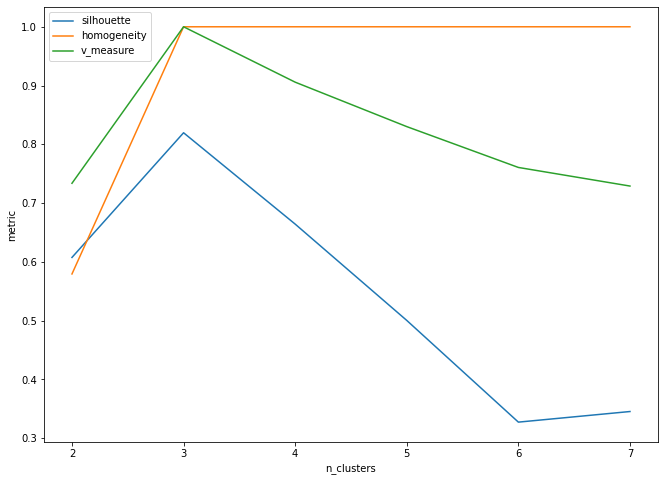

In [9]:
plt.figure(figsize=(11, 8))
plt.plot(range(2,8), silhouette, label='silhouette')
plt.plot(range(2,8), homogeneity, label='homogeneity')
plt.plot(range(2,8), v_measure, label='v_measure')
plt.xlabel('n_clusters')
plt.ylabel('metric')
plt.legend(loc='best')
plt.show()

## DBSCAN

Это алгоритм, основанный на плотности — если дан набор объектов в некотором пространстве, алгоритм группирует вместе объекты, которые расположены близко и помечает как выбросы объекты, которые находятся в областях с малой плотностью (ближайшие соседи которых лежат далеко).

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.



Рассмотрим диаграмму, параметр `min_samples`=4.

Точка $A$ и другие красные точки являются основными точками, поскольку область с радиусом 
`eps` , окружающая эти точки, содержит по меньшей мере 4 точки (включая саму точку). Поскольку все они достижимы друг из друга, точки образуют один кластер. Точки $B$ и $C$ основными не являются, но достижимы из $A$ (через другие основные точки), и также принадлежат кластеру. Точка $N$ является точкой шума, она не является ни основной точкой, ни доступной прямо.

<p><a href="https://commons.wikimedia.org/wiki/File:DBSCAN-Illustration.svg#/media/Файл:DBSCAN-Illustration.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/1200px-DBSCAN-Illustration.svg.png" alt="DBSCAN-Illustration.svg" width="450" height="450"> </a><br>Автор: <a href="//commons.wikimedia.org/wiki/User:Chire" title="User:Chire">Chire</a> &mdash; <span class="int-own-work" lang="ru">собственная работа</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>

Посмотрим на результаты кластеризации при разном выборе параметров `eps` и `min_samples`.

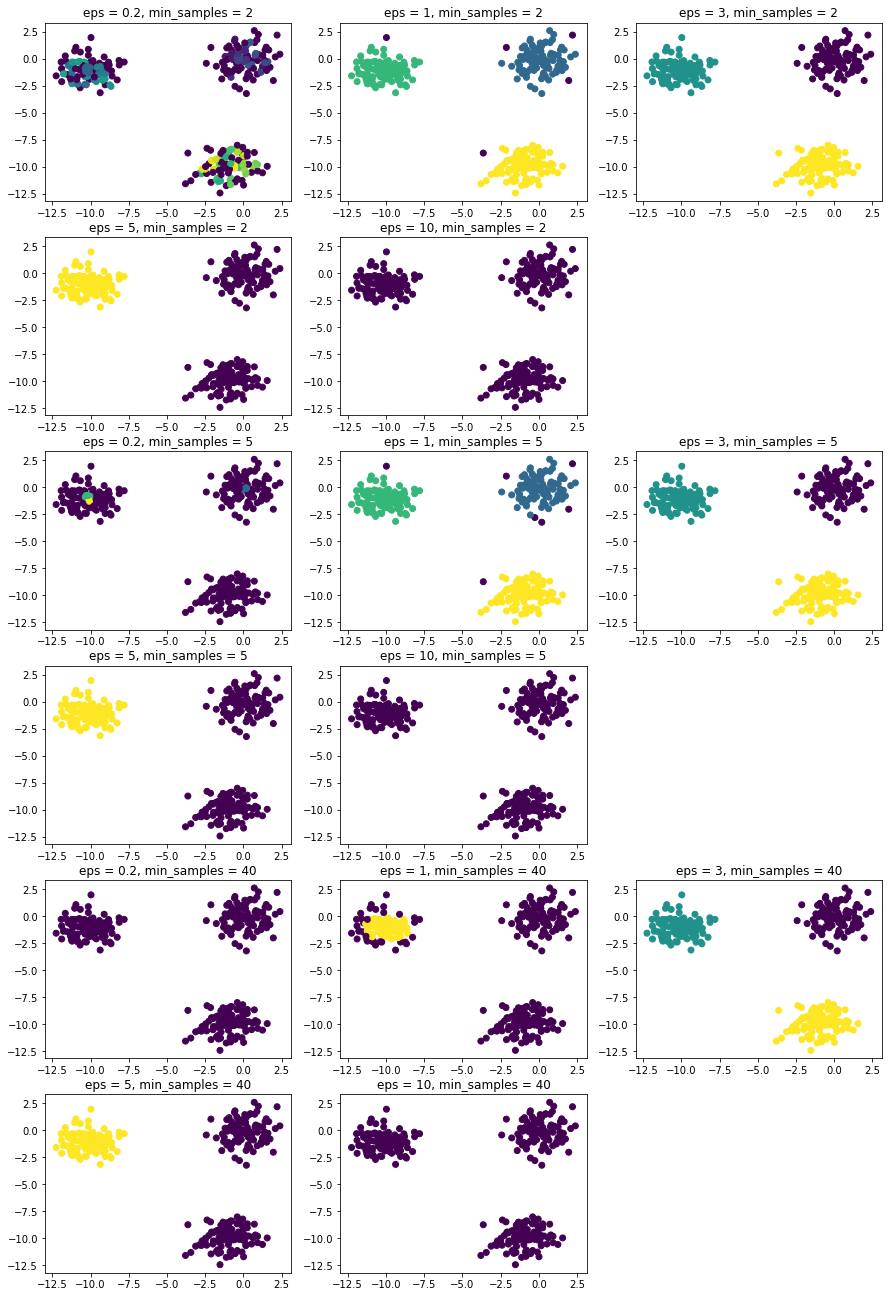

In [10]:
from sklearn.cluster import DBSCAN
plt.figure(figsize=(15,23))
i = 1
for samples in [2, 5, 40]:
    for e in [0.2, 1, 3, 5, 10]:
        dbscan = DBSCAN(eps=e, min_samples=samples)
        clusters = dbscan.fit_predict(X)
        plt.subplot(6, 3, i)
        plt.scatter(X[:,0], X[:,1], c=clusters)
        plt.title('eps = {}, min_samples = {}'.format(e, samples))
        i += 1
    i += 1

plt.show()

[Визуализация работы DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

Результаты работы методов на других датасетах:

In [11]:
from sklearn.datasets import make_moons, make_circles

In [12]:
X, y = make_moons(n_samples=500, noise=0.1)

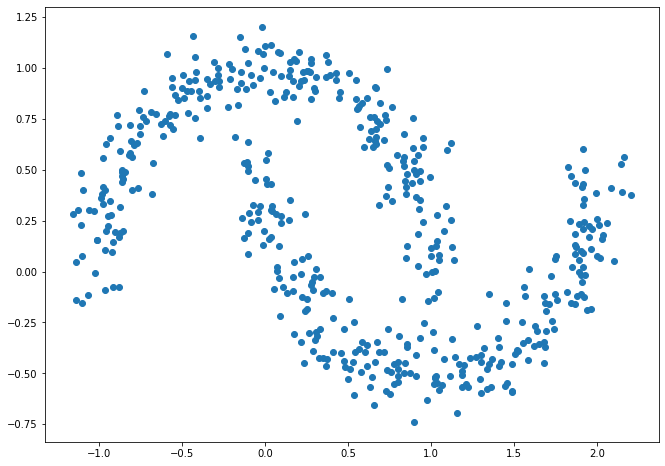

In [13]:
plt.scatter(X[:,0], X[:,1])
plt.show()

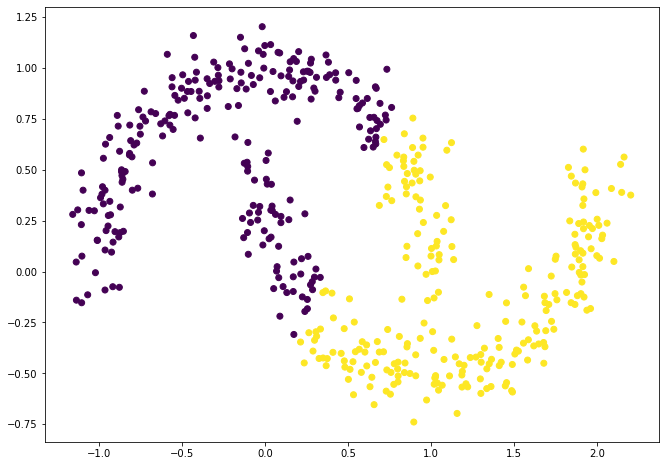

In [14]:
k_means = KMeans(n_clusters=2)
k_means = k_means.fit(X)
clusters = k_means.predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

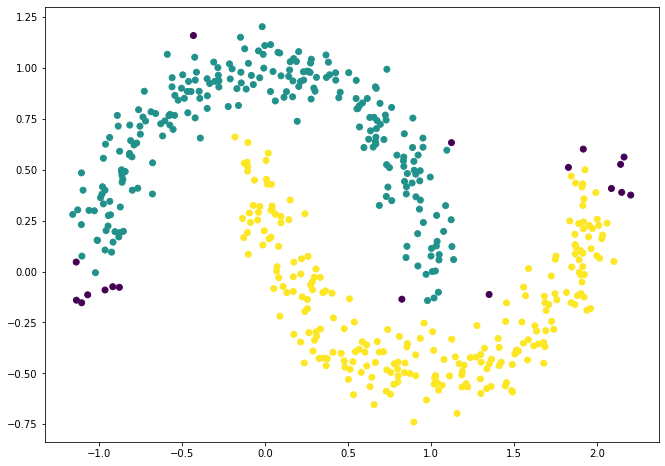

In [15]:
dbscan = DBSCAN(eps=0.15, min_samples=10)
clusters = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

In [16]:
X, y = make_circles(n_samples=500, noise=0.05, factor=0.5)

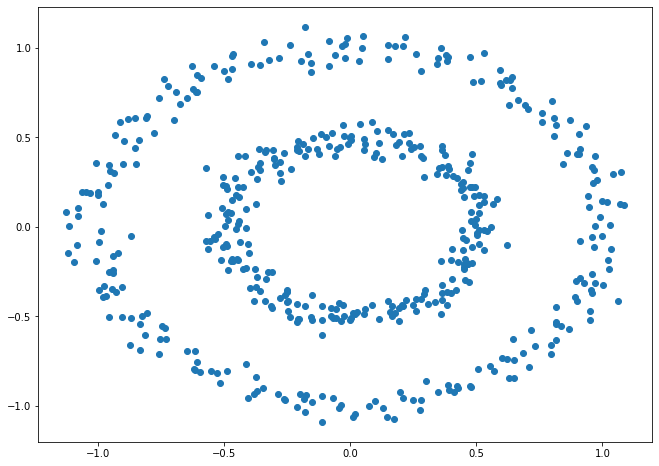

In [17]:
plt.scatter(X[:,0], X[:,1])
plt.show()

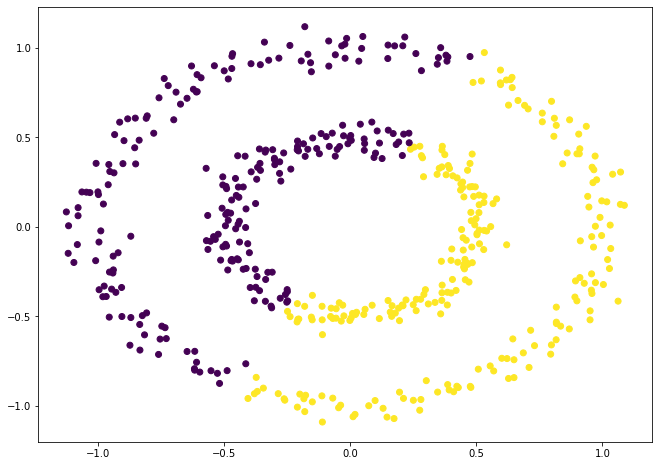

In [18]:
k_means = KMeans(n_clusters = 2)
k_means = k_means.fit(X)
clusters = k_means.predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

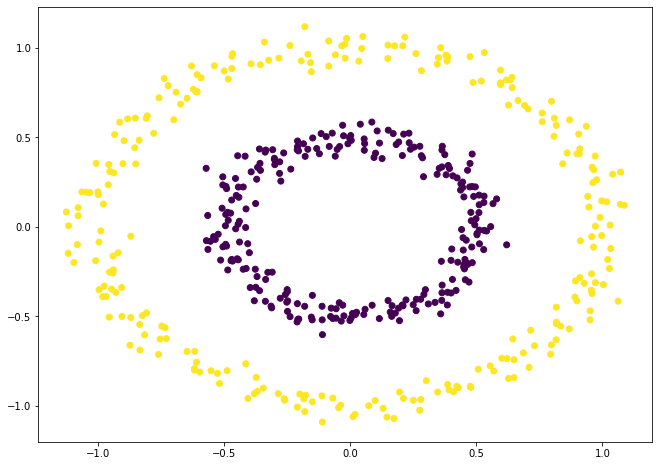

In [19]:
dbscan = DBSCAN(eps=0.2, min_samples=10)
clusters = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

## Иерархическая кластеризация

Другим вариантом к построению кластеров является иерархический подход, в котором алгоритм жадным образом строит кластеры. Существует два варианта иерархической кластеризации:

1. аггломеративная, в которой алгоритм на каждой итерации объединяет два меньших кластера в один
2. дивизивная, в которой алгоритм на каждой итерации разбивает один кластер на два более мелких

Мы рассмотрим аггломеративный подход к кластеризации (дивизивный можно рассмотреть по аналогии).

Опишем схематически алгоритм аггломеративной иерархической кластеризации:

- Инициализируем наше множество кластеров, каждая точка считается своим кластером. То есть для выборки размера $N$ у нас на первой итерации будет $N$ кластеров. Также в качестве входного параметра алгоритму подается метрика расстояния между двумя кластерами. Одной из популярных метрик является расстояние Уорда.

- На каждой итерации  мы объединяем два кластера в один. Объединяющиеся кластера выбираются в соответствии с наименьшим расстоянием Уорда. То есть в соответствии с выбранным нами расстоянием эти два кластера будут наиболее похожи и поэтому объединяются.

- Предыдущий шаг повторяется вплоть до объединения всех точек один кластер.

Расстояние Уорда — между кластерами берётся прирост суммы квадратов расстояний объектов до центра кластера, получаемого в результате их объединения.

$$ 
\Delta = \sum_i{(x_i-\bar{x})^2} - \sum_{x_i \in A}(x_i - \bar{a})^2 - \sum_{x_i \in B}(x_i - \bar{b})^2
$$

В результате в данном подходе мы можем выбрать любое количество кластеров после завершения процедуры, просто остановив алгоритм на нужном нам шаге.

Для визуализации иерархической кластеризации удобно строить дендрограммы, в которых разница между уровнями равна выбранному расстоянию объединяющихся на данном этапе кластеров.

Посмотрим на иерархическую кластеризацию на примере:


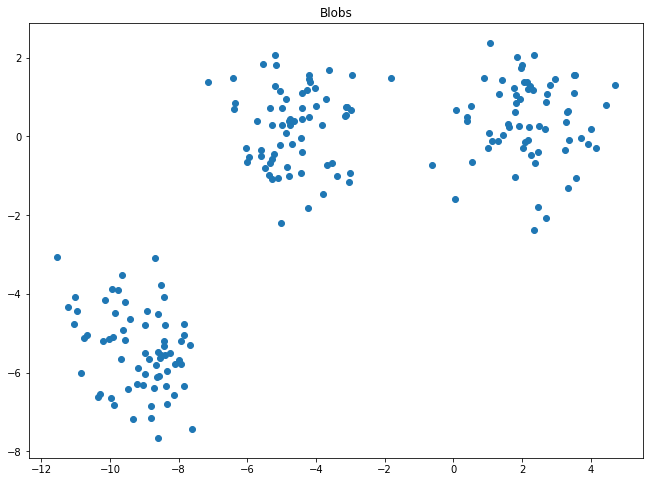

In [20]:
from sklearn.datasets import make_blobs

n_samples = 200
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

plt.scatter(X[:,0], X[:,1])
plt.title('Blobs')
plt.show()

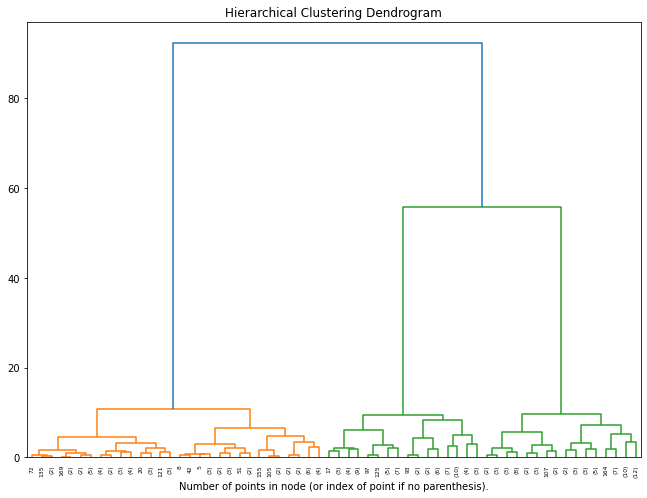

In [21]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


random_state = 170
X, _ = make_blobs(n_samples=n_samples, random_state=random_state)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

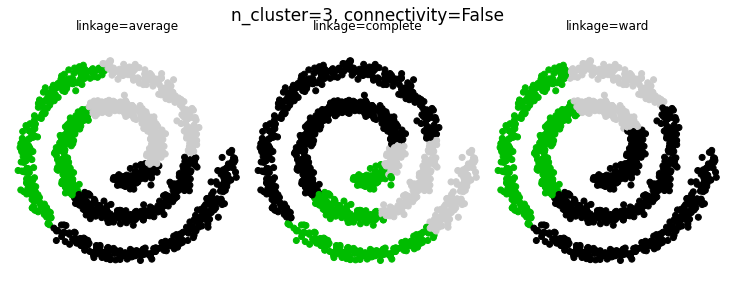

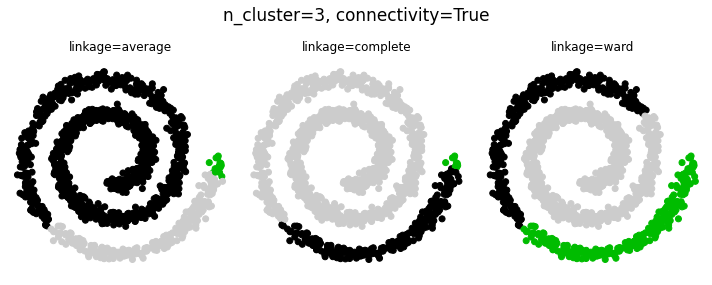

In [22]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

n_clusters = 3
for connectivity in (None, knn_graph):
    plt.figure(figsize=(10, 4))
    for index, linkage in enumerate(('average',
                                     'complete',
                                     'ward')):
        plt.subplot(1, 3, index + 1)
        model = AgglomerativeClustering(linkage=linkage,
                                        connectivity=connectivity,
                                        n_clusters=n_clusters)
        model.fit(X)
        plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                    cmap=plt.cm.nipy_spectral)
        plt.title('linkage=%s' % linkage,
                  fontdict=dict(verticalalignment='top'))
        plt.axis('equal')
        plt.axis('off')

        plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                            left=0, right=1)
        plt.suptitle('n_cluster=%i, connectivity=%r' %
                     (n_clusters, connectivity is not None), size=17)

plt.tight_layout()
plt.show()

Если нет каких-то специализированных условий (например, известно, что кластеров должно быть не более $K$), то число кластеров можно выбирать по резкому скачку дендрограммы. Кроме того, в некоторых задачах важно понимать, для чего делается кластеризация и доменную область задачи — исходя из этого можно сильно сократить искомое количество кластеров.

## Сравнение работы алгоритмов

Сгенерируем кластеры разной формы и посмотрим на результаты работы алгоритмов

Automatically created module for IPython interactive environment


/Library/Python/3.8/site-packages/sklearn/cluster/_agglomerative.py:476: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/Library/Python/3.8/site-packages/sklearn/cluster/_agglomerative.py:476: UserWarning: the number of connected components of the connectivity matrix is 78 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/Library/Python/3.8/site-packages/sklearn/cluster/_agglomerative.py:476: UserWarning: the number of connected components of the connectivity matrix is 51 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/Library/Python/3.8/site-packages/sklearn/cluster/_agglomerative.py:476: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree e

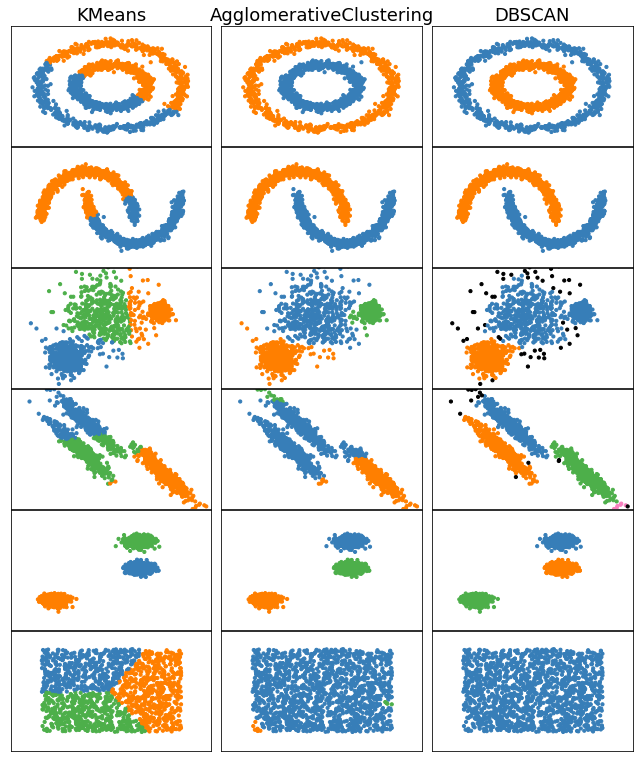

In [23]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(3 * 2 + 3, 10.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    connectivity = kneighbors_graph(
        X,
        n_neighbors=params['n_neighbors'],
        include_self=False
    )
    
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    
    k_means = cluster.KMeans(n_clusters=params['n_clusters'])

    dbscan = cluster.DBSCAN(eps=params['eps'])
    
    average_linkage =  cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'],
        connectivity=connectivity
    )
    

    clustering_algorithms = (
        ('KMeans', k_means),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
    )

    for name, algorithm in clustering_algorithms:

        algorithm.fit(X)

        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()